# Figure 007 (v001)

Effect of knocking out drivers when mutated

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Sequence

import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text
from scipy.cluster.hierarchy import leaves_list, linkage

In [3]:
import speclet.plot as sp
from speclet.io import figure_img_file, tables_dir
from speclet.plot.color_pal import pal_to_legend_handles

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sp.set_speclet_theme(sp.PlottingMode.DISSERTATION)

In [5]:
FIGNUM, VERSION = 7, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "driver-mutations")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_007-v001/fig_007-v001_driver-mutations.png')

In [6]:
notebook_output_dir = tables_dir() / "100_110_gene-mutation-effect"

### Data

In [7]:
drivers_f_post = pd.read_csv(
    notebook_output_dir / "cgc-drivers-f-posterior-summariers.csv"
)
ras_raf_data = pd.read_csv(notebook_output_dir / "ras-raf-genes-data.csv")
cgc_mut_data = pd.read_csv(notebook_output_dir / "cgc-cancer-drivers-mutations.csv")
ras_params = pd.read_csv(notebook_output_dir / "ras-genes-model-parameters.csv")
raf_params = pd.read_csv(notebook_output_dir / "raf-genes-model-parameters.csv")

## Figure

### Shared

In [8]:
FIGSIZE = (6.5, 7.5)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(nrows=2, ncols=1, height_ratios=(1.1, 1))

panel_a = subfigures[0]
bottom_row = subfigures[1].subfigures(ncols=2)
panel_b = bottom_row[0]
panel_c = bottom_row[1]

<Figure size 650x750 with 0 Axes>

### a. Heatmap of known cancer drivers

In [9]:
def hclust(x: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    row_cls = linkage(x, method="average", metric="euclidean", optimal_ordering=True)
    col_cls = linkage(x.T, method="average", metric="euclidean", optimal_ordering=True)
    row_idx = leaves_list(row_cls)
    col_idx = leaves_list(col_cls)
    y = x.copy().iloc[row_idx, col_idx]
    return y, row_idx, col_idx

In [10]:
def extract_subtype(t: str) -> str:
    if "(" not in t:
        return t
    return t.split("(")[1].replace(")", "").strip()


def extract_subtypes(ts: Sequence[str]) -> list[str]:
    return [extract_subtype(t) for t in ts]


def extract_subtype_from_label(lbl: Text) -> Text:
    lbl.set_text(extract_subtype(lbl.get_text()))
    return lbl


def extract_subtype_from_labels(lbls: Sequence[Text]) -> list[Text]:
    return [extract_subtype_from_label(lbl) for lbl in lbls]

In [11]:
nonzero_hdi_cgc = drivers_f_post.query("not zero_hdi")["hugo_symbol"].unique().tolist()

cgc_mutant_counts = (
    cgc_mut_data.filter_column_isin(
        "hugo_symbol", drivers_f_post["hugo_symbol"].toset()
    )
    .filter_column_isin("lineage_subtype", drivers_f_post["lineage_subtype"].toset())
    .filter_column_isin("hugo_symbol", nonzero_hdi_cgc)
    .query("is_mutated")
    .groupby(["lineage_subtype", "hugo_symbol"])["depmap_id"]
    .count()
    .reset_index()
)

cgc_mutant_counts_X = (
    cgc_mutant_counts.pivot_wider(
        ["lineage_subtype"], names_from="hugo_symbol", values_from="depmap_id"
    )
    .set_index("lineage_subtype")
    .fillna(0)
)

In [12]:
panel_a.clear()
panel_a.text(0, 0.98, r"$\textbf{a}$", fontsize=8)
ax = panel_a.subplots()


X = (
    drivers_f_post.filter_column_isin("hugo_symbol", nonzero_hdi_cgc)
    .merge(cgc_mutant_counts, on=["lineage_subtype", "hugo_symbol"], how="left")
    .fillna({"depmap_id": 0})
    .assign(is_mut=lambda d: d["depmap_id"] > 0)
    .assign(mean=lambda d: d["is_mut"] * d["mean"])
    .pivot_wider(["lineage_subtype"], names_from="hugo_symbol", values_from="mean")
    .set_index("lineage_subtype")
)

X_scaled = (X.T / X.T.std()).T
assert X_scaled.shape == cgc_mutant_counts_X.shape
assert np.all(X_scaled.index == cgc_mutant_counts_X.index)
assert np.all(X_scaled.columns == cgc_mutant_counts_X.columns)

X_scaled, row_idx, col_idx = hclust(X_scaled)
mask = cgc_mutant_counts_X.copy().iloc[row_idx, col_idx]
mask = mask == 0


sns.heatmap(
    X_scaled,
    cmap="seismic",
    center=0,
    xticklabels=1,
    yticklabels=1,
    ax=ax,
    mask=mask,
    cbar_kws={"pad": 0.02, "shrink": 0.8, "aspect": 40},
)
ax.set_yticklabels(extract_subtype_from_labels(ax.get_yticklabels()))
ax.tick_params("y", labelsize=6, pad=1)


def _italicize(lbl: Text) -> Text:
    t = lbl.get_text()
    lbl.set_text(rf"$\textit{{{t}}}$")
    return lbl


ax.set_xticklabels([_italicize(lbl) for lbl in ax.get_xticklabels()])

ax.tick_params(
    axis="x",
    bottom=True,
    top=True,
    labelbottom=True,
    labeltop=True,
    rotation=90,
    labelsize=5,
    pad=1,
)

plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()[::2]], alpha=0)
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()[1::2]], alpha=0)

for i in np.arange(X_scaled.shape[0]):
    ax.axhline(i, lw=0.5, c="lightgrey", zorder=100)
for i in np.arange(X_scaled.shape[1]):
    ax.axvline(i, lw=0.5, c="lightgrey", zorder=100)

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_facecolor([229 / 255, 229 / 255, 229 / 255, 255 / 255])

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_title(r"$\bar{f}$")

Text(0.5, 1.0, '$\\bar{f}$')

### b. Ras family $f$ post

In [13]:
gene_mutant_counts = (
    ras_raf_data[["lineage_subtype", "depmap_id", "hugo_symbol", "is_mutated"]]
    .query("is_mutated")
    .drop_duplicates()
    .reset_index(drop=True)
    .groupby(["lineage_subtype", "hugo_symbol"])["depmap_id"]
    .count()
    .reset_index()
)

In [14]:
def _order_lineages(df: pd.DataFrame, gene_scores: dict[str, float]) -> pd.DataFrame:
    subline_order = (
        df.assign(
            score=lambda d: d["hugo_symbol"].astype(str).map(gene_scores) ** 2
            * d["mean"]
        )
        .groupby("lineage_subtype")["score"]
        .sum()
        .reset_index()
        .sort_values("score", ascending=False)["lineage_subtype"]
        .values.astype("str")
    )
    df["lineage_subtype"] = pd.Categorical(
        df["lineage_subtype"], categories=subline_order, ordered=True
    )
    return df


def _plot_gene_family_f_posterior(
    gene_params: pd.DataFrame,
    mutations_df: pd.DataFrame,
    gene_scores: dict[str, float],
    pal: dict[str, str],
    axes: np.ndarray,
) -> None:
    lineages_with_mutations = (
        mutations_df.copy()
        .filter_column_isin("lineage_subtype", gene_params["lineage_subtype"].toset())
        .filter_column_isin("hugo_symbol", gene_params["hugo_symbol"].toset())
        .query("depmap_id > 0")["lineage_subtype"]
        .unique()
    )

    plot_df = (
        gene_params.copy()
        .filter_column_isin("lineage_subtype", lineages_with_mutations)
        .query("var_name == 'f'")
        .pipe(_order_lineages, gene_scores=gene_scores)
        .astype({"hugo_symbol": "category"})
    )
    dx = np.linspace(-0.3, 0.3, plot_df["hugo_symbol"].nunique())
    offset = dict(zip(plot_df["hugo_symbol"].cat.categories, dx))

    ax = axes[0]
    for lineage, df in plot_df.groupby("lineage_subtype"):
        y = df["lineage_subtype"].cat.codes.values
        y = y + np.array(df["hugo_symbol"].map(offset).tolist())
        colors = df["hugo_symbol"].map(pal).tolist()

        ax.scatter(x=df["mean"], y=y, s=1, color=colors, zorder=10)
        ax.hlines(
            y=y,
            xmin=df["hdi_5.5%"],
            xmax=df["hdi_94.5%"],
            color=colors,
            zorder=8,
            alpha=0.5,
            lw=0.7,
        )
        for i, g in enumerate(df["hugo_symbol"].cat.categories):
            n_muts = mutations_df.query(
                f"hugo_symbol == '{g}' and lineage_subtype == '{lineage}'"
            )
            assert len(n_muts) <= 1
            if len(n_muts) == 0:
                n = 0
            else:
                n = n_muts["depmap_id"].values[0]
            axes[1].text(i, np.median(y), f"${n}$", ha="center", va="center", size=5.5)

    for i in range(plot_df["lineage_subtype"].nunique() - 1):
        ax.axhline(i + 0.5, lw=0.4, c="grey", alpha=0.5, zorder=1)

    ax.set_yticks(
        ticks=np.arange(0, plot_df["lineage_subtype"].nunique()),
        labels=extract_subtypes(plot_df["lineage_subtype"].cat.categories),
        fontsize=6,
    )
    ax.grid(False, axis="y")
    ax.axvline(0, lw=0.5, c="k", zorder=2)
    ax.set_ylim(-0.5, plot_df["lineage_subtype"].nunique() - 0.5)
    ax.set_ylabel(None)
    ax.set_xlabel("posterior $f$\n" + r"mean \& 89\% HDI")

    mod_pal = {rf"$\textit{{{k}}}$": v for k, v in pal.items()}
    ax.legend(
        handles=pal_to_legend_handles(mod_pal, lw=0, marker="o", markersize=2),
        loc="lower left",
        borderaxespad=0.3,
        handlelength=0,
        handletextpad=0.5,
        frameon=True,
        edgecolor="white",
        framealpha=0.7,
    )

    axes[1].grid(False, axis="both")
    axes[1].set_xticks(
        ticks=np.arange(plot_df["hugo_symbol"].nunique()),
        labels=[rf"$\textit{{{x}}}$" for x in plot_df["hugo_symbol"].cat.categories],
        rotation=90,
        ha="center",
    )

In [15]:
panel_b.clear()
panel_b.text(0, 0.98, r"$\textbf{b}$", fontsize=8)
axes = panel_b.subplots(
    nrows=1,
    ncols=2,
    squeeze=True,
    sharey=True,
    sharex=False,
    gridspec_kw={"width_ratios": (5, 1)},
)
ras_pal = {"HRAS": "#344D5E", "KRAS": "#BC0F4C", "NRAS": "#FFA702"}
_plot_gene_family_f_posterior(
    ras_params,
    mutations_df=gene_mutant_counts,
    gene_scores={"HRAS": 1, "KRAS": 3, "NRAS": 2},
    pal=ras_pal,
    axes=axes,
)

### c. Raf family $f$ post

In [16]:
panel_c.clear()
panel_c.text(0, 0.98, r"$\textbf{c}$", fontsize=8)
axes = panel_c.subplots(
    nrows=1,
    ncols=2,
    squeeze=True,
    sharey=True,
    sharex=False,
    gridspec_kw={"width_ratios": (5, 1)},
)
raf_pal = {"ARAF": "#4B86B4", "BRAF": "#623178", "RAF1": "#8DCA40"}
_plot_gene_family_f_posterior(
    raf_params,
    mutations_df=gene_mutant_counts,
    gene_scores={"ARAF": 3, "BRAF": 2, "RAF1": 1},
    pal=raf_pal,
    axes=axes,
)

## Saving

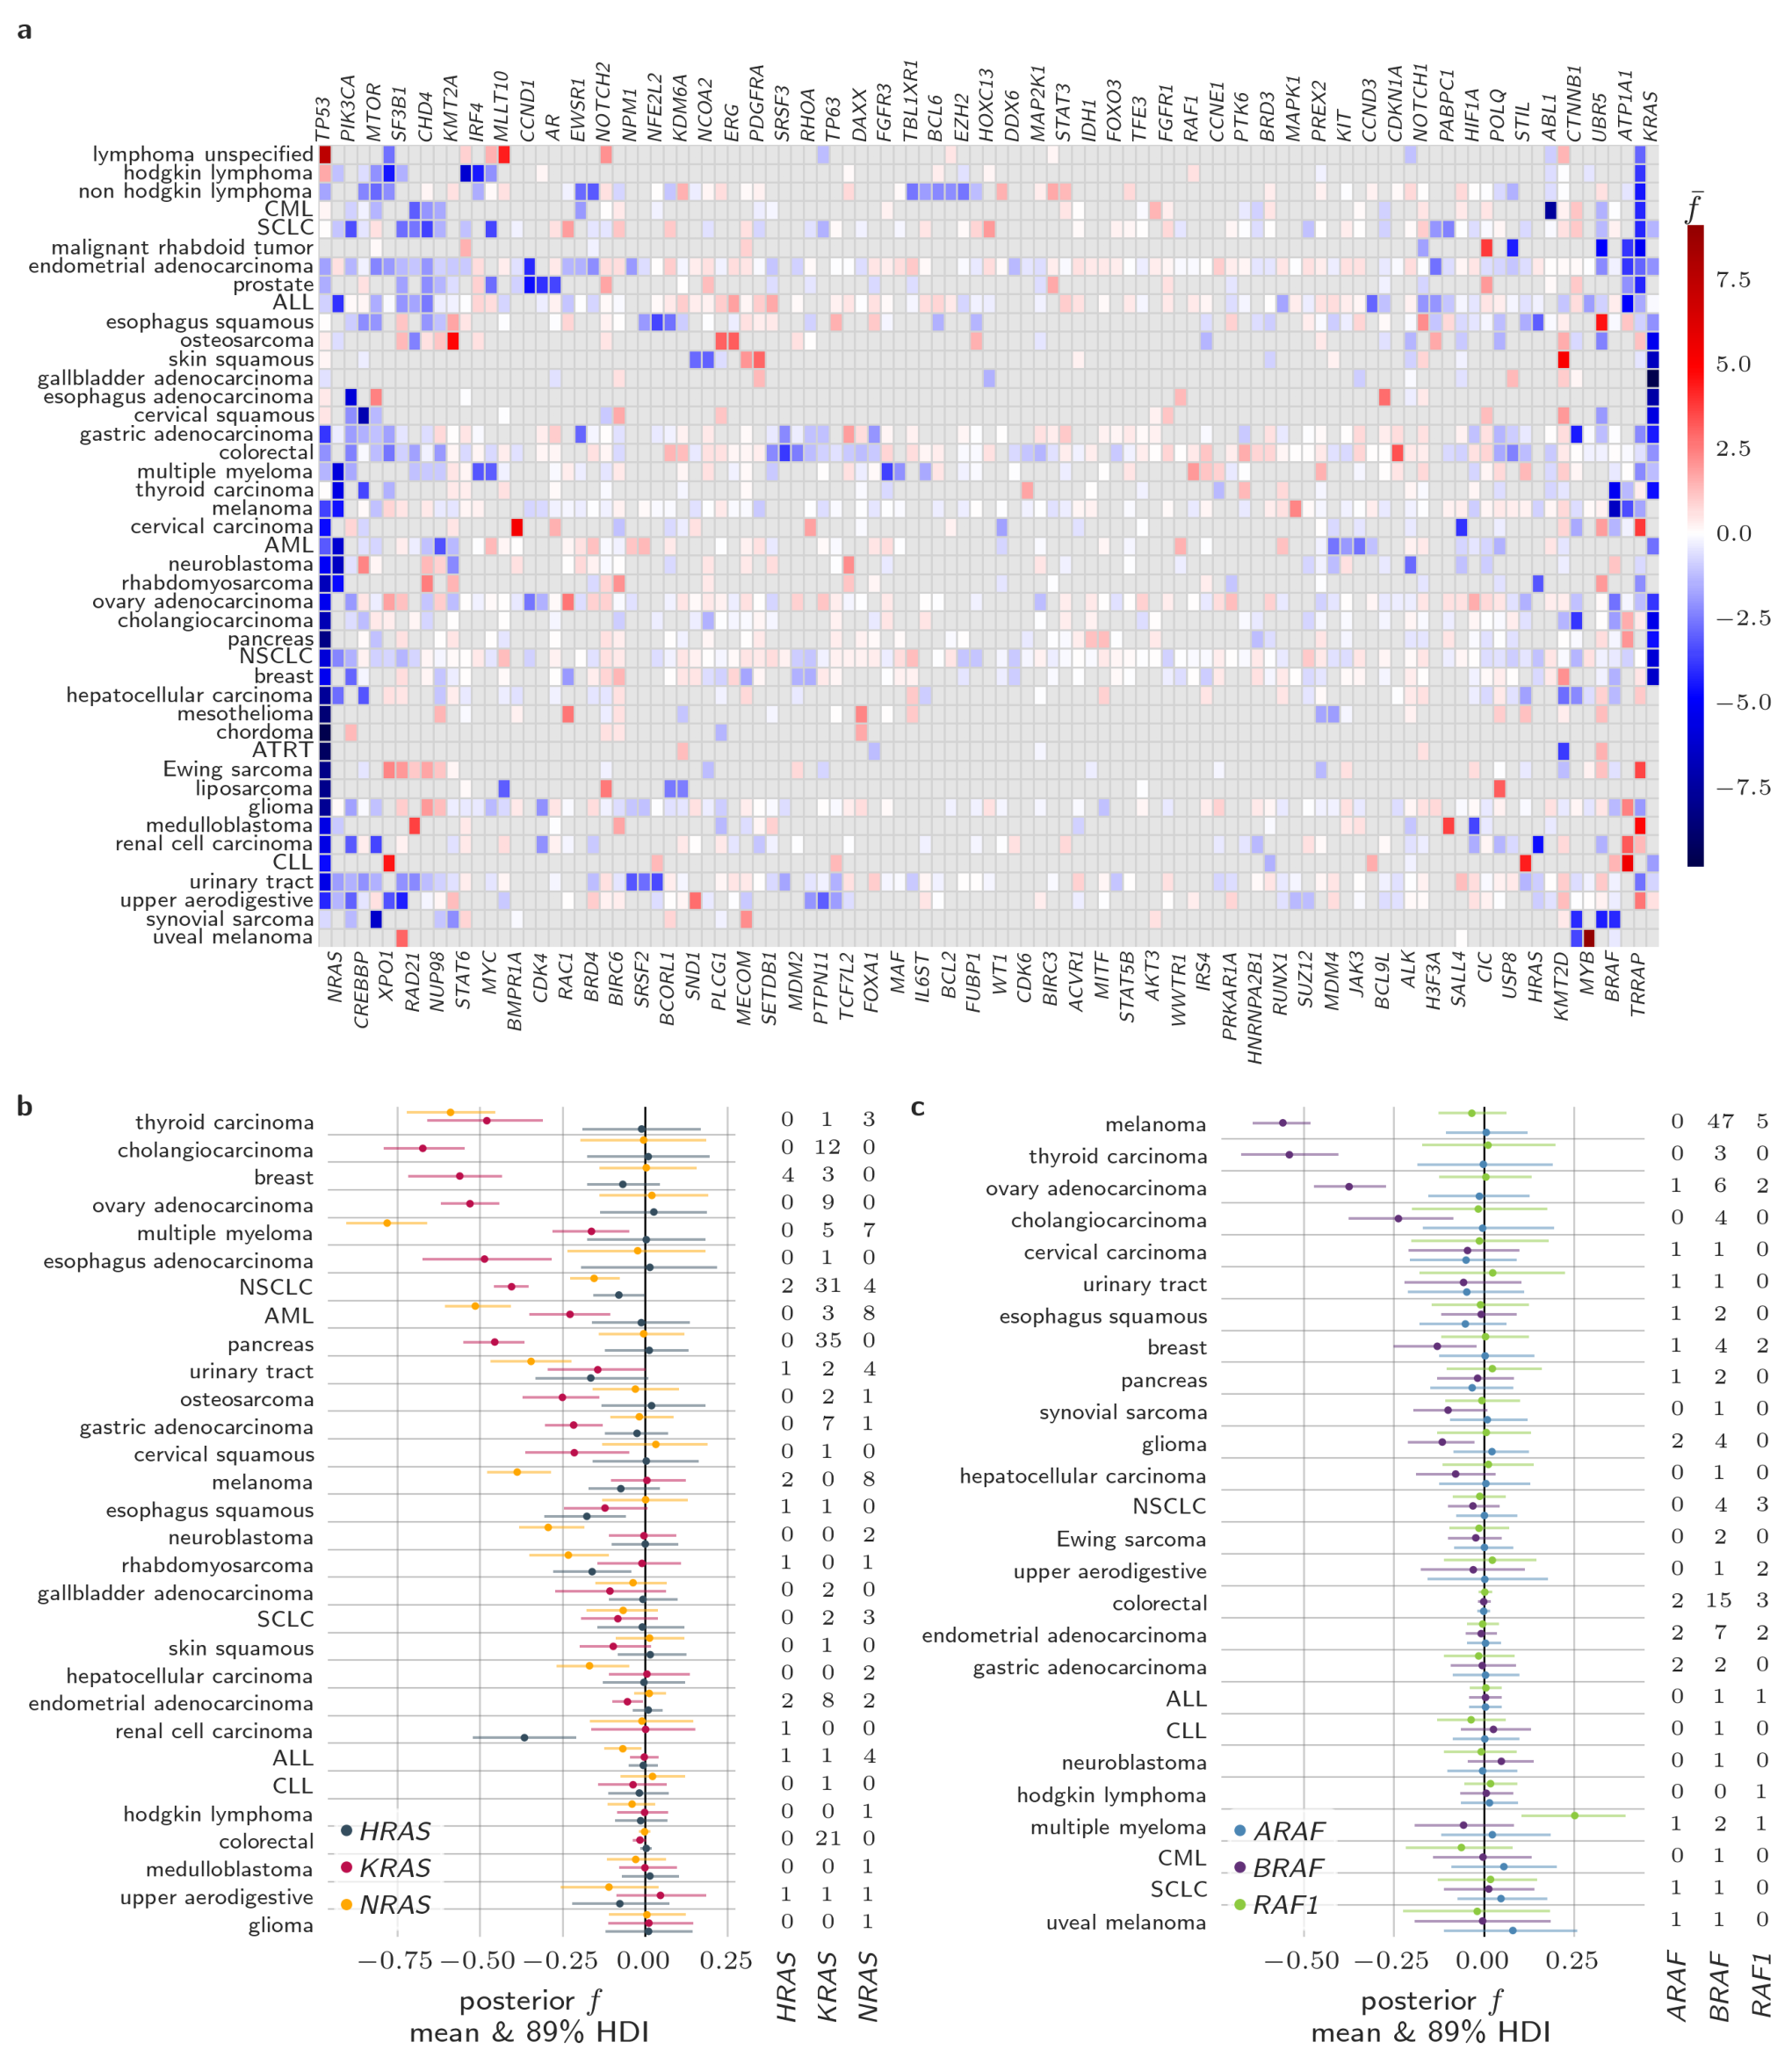

In [17]:
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0, bbox_inches="tight")

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [18]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-23

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-236.o2.rc.hms.harvard.edu

Git branch: figures

pandas    : 1.4.4
janitor   : 0.22.0
speclet   : 0.0.9000
matplotlib: 3.5.3
seaborn   : 0.11.2
numpy     : 1.23.3

